# Predicting the ideal suburb for property purchase

### Business Problem

#### This capstone project is inspired by the idea of extracting the region where a house/apartment purchase can lead to maximum annual revenue for the owner through rental bonds. This project also explores the chosen datasets by summarizing the features of such a home. It analyses existing data of homes in Sydney suburbs and decides on an ideal suburb.

#### Necessary libraries installation

In [1]:
import pandas as pd
from requests import get
import numpy as np

In [2]:
!pip install lxml --user

In [3]:
!pip install beautifulsoup4 --user

# Data collection and wrangling
#### In this step, we will prepare our final dataset (dataframe) for analysis

#### Get Sydney suburbs list

In [12]:
import requests
from bs4 import BeautifulSoup

def get_suburbs(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    suburb_list = soup.find_all('div', class_="mw-category")[1].find_all('div', class_="mw-category-group")
    return suburb_list

def get_content(row_link):
    li = []
    for s in row_link:
        for lis in s.find_all('li'):
             li.append(lis.get_text())
    return li

suburbs_list = []
li = get_suburbs("https://en.wikipedia.org/wiki/Category:Suburbs_of_Sydney")
suburbs_list.append(get_content(li))
li = get_suburbs("https://en.wikipedia.org/w/index.php?title=Category:Suburbs_of_Sydney&pagefrom=Dharruk%2C+New+South+Wales#mw-pages")
suburbs_list.append(get_content(li))
li = get_suburbs("https://en.wikipedia.org/w/index.php?title=Category:Suburbs_of_Sydney&pagefrom=Macgraths+Hill%0AMcGraths+Hill%2C+New+South+Wales#mw-pages")
suburbs_list.append(get_content(li))
li = get_suburbs("https://en.wikipedia.org/w/index.php?title=Category:Suburbs_of_Sydney&pagefrom=Singletons+Mill%2C+New+South+Wales#mw-pages")
suburbs_list.append(get_content(li))

suburbs_df = pd.DataFrame(columns=["Suburb"])
rowIndex = 0
for suburb in suburbs_list:
    for s in suburb:
        suburnName = s.split(',')
        suburbs_df.loc[rowIndex, 'Suburb'] = suburnName[0]
        rowIndex=rowIndex+1

suburbs_df.drop(suburbs_df.index[0], inplace = True)
suburbs_df.reset_index(inplace = True)
del suburbs_df['index']
suburbs_df_lower = pd.DataFrame(suburbs_df['Suburb'].str.lower())
print("Only suburbs table size : ", suburbs_df_lower.shape)
suburbs_df_lower.head(5)

Only suburbs table size :  (710, 1)


,Suburb
0,abbotsbury
1,abbotsford
2,acacia gardens
3,agnes banks
4,airds


#### Get postcodes and add them to the main dataframe

In [13]:
postCode_df = pd.DataFrame(columns=['PostCode'])
suburbs_df_lower = suburbs_df_lower.append(postCode_df) #append postcode column to main dataframe

NswSuburbMedianPrice_df = pd.DataFrame(pd.read_csv('NswSuburbMedianPrice2007-2020.csv'))
NswSuburbMedianPrice_df['suburb'] = pd.DataFrame(NswSuburbMedianPrice_df['suburb'].str.lower()) #convert suburb column to lowercase
for index, row in suburbs_df_lower.iterrows():
    suburb = suburbs_df_lower.iloc[index]['Suburb']
    l = NswSuburbMedianPrice_df.index[NswSuburbMedianPrice_df['suburb'] == suburb].tolist()
    if len(l) != 0:
        i = l[0]
        suburbs_df_lower.iloc[index]['PostCode'] = NswSuburbMedianPrice_df.iloc[i]['postcode']
    
suburbs_df_lower = suburbs_df_lower.dropna()
print("Suburbs with post code table size : ", suburbs_df_lower.shape)
suburbs_df_lower = suburbs_df_lower.reset_index(drop = True)
suburbs_df_lower.head()

Suburbs with post code table size :  (524, 2)


,Suburb,PostCode
0,abbotsbury,2176
1,abbotsford,2046
2,acacia gardens,2763
3,airds,2560
4,alexandria,2015


In [14]:
#get unit/house
from sklearn import preprocessing

Postcode_rents_df = pd.DataFrame(pd.read_csv('Postcode_rents.csv'))
Postcode_rents_df = Postcode_rents_df[Postcode_rents_df['Dwelling Types'].notna()] #remove rows with dwelling type = NaN
types = Postcode_rents_df['Dwelling Types'].unique()
type_df = pd.DataFrame(columns=types)

#Transform dwelling types to 0,1,2,3,4
le_type = preprocessing.LabelEncoder()
le_type.fit(['Total', 'House', 'Other', 'Townhouse', 'Flat/Unit'])
Postcode_rents_df['Dwelling Types'] = le_type.transform(Postcode_rents_df['Dwelling Types']) 

#### Add data from Postcode_rents file, this includes FirstQuartileWeeklyRent, PropertyType and others

In [15]:
df2 = pd.DataFrame(columns=['Suburb', 'PostCode', 'PropertyType', 'NumberOfBeds', 'FirstQuartileWeeklyRent', 'MedianWeeklyRent', 'ThirdQuartileWeeklyRent', 'NewBondsLodged', 'TotalBondsHeld', 'AnnualChangeInNewBonds', 'AnnualChangeInWeeklyRent'])

for index, row in suburbs_df_lower.iterrows():
    code = suburbs_df_lower.iloc[index]['PostCode']
    suburb = suburbs_df_lower.iloc[index]['Suburb']
    new_df = pd.DataFrame(Postcode_rents_df.loc[Postcode_rents_df['Postcode'] == code])
    new_df = new_df.reset_index()
    for index, row in new_df.iterrows():
        code = new_df.iloc[index]['Postcode']
        dtype = new_df.iloc[index]['Dwelling Types']
        beds = new_df.iloc[index]['Number of Bedrooms']
        fQrent, mrent, tQrent = new_df.iloc[index]['First Quartile Weekly Rent for New Bonds\n$'], new_df.iloc[index]['Median Weekly Rent for New Bonds\n$'], new_df.iloc[index]['Third Quartile Weekly Rent for New Bonds\n$']
        nbonds, tbonds, chgnbonds = new_df.iloc[index]['New Bonds Lodged\nNo.'], new_df.iloc[index]['Total Bonds Held\nNo.'], new_df.iloc[index]['Annual change in New Bonds Lodged']
        chgrent = new_df.iloc[index]['Annual change in Median Weekly Rent']
        new_row = {'Suburb' : suburb,
                   'PostCode' : code, 
                   'PropertyType' : dtype,
                   'NumberOfBeds' : beds, 
                   'FirstQuartileWeeklyRent' : fQrent, 
                   'MedianWeeklyRent' : mrent, 
                   'ThirdQuartileWeeklyRent' : tQrent, 
                   'NewBondsLodged' : nbonds, 
                   'TotalBondsHeld' : tbonds, 
                   'AnnualChangeInNewBonds' : chgnbonds, 
                   'AnnualChangeInWeeklyRent' : chgrent}
        df2 = df2.append(new_row, ignore_index = True)
    
print("Shape before : ", df2.shape)        
#df2.head(20)

Shape before :  (17404, 11)


In [16]:
#remove empty or null value rows
df2 = df2[df2.FirstQuartileWeeklyRent.apply(lambda x: x.isnumeric())]
print("Shape after : ", df2.shape)
df2 = df2[df2.NewBondsLodged.apply(lambda x: x.isnumeric())]
print("Shape after : ", df2.shape)
df2['PostCode'] = df2['PostCode'].astype(np.int64)
df2 = df2.reset_index(drop=True)
df2.head(10)

Shape after :  (6598, 11)
Shape after :  (3896, 11)


,Suburb,PostCode,PropertyType,NumberOfBeds,FirstQuartileWeeklyRent,MedianWeeklyRent,ThirdQuartileWeeklyRent,NewBondsLodged,TotalBondsHeld,AnnualChangeInNewBonds,AnnualChangeInWeeklyRent
0,abbotsbury,2176,3,Total,420,500,570,133,"2,422",-20.83%,2.56%
1,abbotsbury,2176,3,2 Bedrooms,370,380,400,33,374,-26.67%,-5.00%
2,abbotsbury,2176,3,3 Bedrooms,480,510,545,58,1241,-10.77%,2.00%
3,abbotsbury,2176,3,4 or more Bedrooms,570,620,660,32,617,-25.58%,3.33%
4,abbotsbury,2176,1,Total,485,530,600,89,1659,-9.18%,0.00%
5,abbotsbury,2176,1,3 Bedrooms,480,500,550,45,955,-8.16%,0.00%
6,abbotsbury,2176,1,4 or more Bedrooms,570,620,660,31,569,-22.50%,3.33%
7,abbotsford,2046,3,Total,495,580,700,241,3040,-13.31%,-9.02%
8,abbotsford,2046,3,1 Bedroom,400,450,500,34,281,30.77%,-7.22%
9,abbotsford,2046,3,2 Bedrooms,488,565,623,135,1631,-8.78%,-5.83%


#### Get train station (if present) in each suburb

In [17]:
url = "https://en.wikipedia.org/wiki/List_of_Sydney_Trains_railway_stations"
df_list = pd.read_html(url)
df = pd.DataFrame(df_list[1])
trainStation_list = df['Name'].str.lower().tolist()

trains_column = pd.DataFrame(columns=['TrainStationPresent'])
df2 = df2.append(trains_column)
for index, row in df2.iterrows():
    suburb = df2.iloc[index]['Suburb']
    if df2.iloc[index]['Suburb'] in trainStation_list:
        df2.loc[df2['Suburb'] == suburb, 'TrainStationPresent'] = 1
        #df2.iloc[index]['TrainStationPresent'] = 1
    else:
        df2.loc[df2['Suburb'] == suburb, 'TrainStationPresent'] = 0
        
df2.to_csv (r'trainstation_dataframe.csv', index = False, header=True)

In [13]:
df2.to_csv (r'supermarkets_dataframe.csv', index = False, header=True)

In [18]:
df2['AnnualChangeInWeeklyRent'] = df2['AnnualChangeInWeeklyRent'].str.strip('%')
df2['AnnualChangeInWeeklyRent'] = df2['AnnualChangeInWeeklyRent'].apply(lambda x: float(x))
#df2['AnnualChangeInWeeklyRent'] = float(df2['AnnualChangeInWeeklyRent'])/100.0

In [19]:
df2.to_csv (r'final_dataframe.csv', index = False, header=True)

In [20]:
#df2['Woolworths'].fillna(0, inplace=True)
#df2['Coles'].fillna(0, inplace=True)
df2['PostCode'] = df2['PostCode'].astype(np.int64)
df2['TrainStationPresent'] = df2['TrainStationPresent'].astype(np.int64)
print("Shape of final dataset : ", df2.shape)
df2.head(5)

Shape of final dataset :  (3896, 12)


,Suburb,PostCode,PropertyType,NumberOfBeds,FirstQuartileWeeklyRent,MedianWeeklyRent,ThirdQuartileWeeklyRent,NewBondsLodged,TotalBondsHeld,AnnualChangeInNewBonds,AnnualChangeInWeeklyRent,TrainStationPresent
0,abbotsbury,2176,3,Total,420,500,570,133,"2,422",-20.83%,2.56,0
1,abbotsbury,2176,3,2 Bedrooms,370,380,400,33,374,-26.67%,-5.00,0
2,abbotsbury,2176,3,3 Bedrooms,480,510,545,58,1241,-10.77%,2.00,0
3,abbotsbury,2176,3,4 or more Bedrooms,570,620,660,32,617,-25.58%,3.33,0
4,abbotsbury,2176,1,Total,485,530,600,89,1659,-9.18%,0.00,0


# Data Visualization/Exploratory Data Analysis
We will analyze the final dataset formed by plotting the relationship between different columns

#### Let's display a Box plot of first, median and third quartile weekly rent

Median for FirstQuartileWeeklyRent : 443.88
Median for MedianWeeklyRent : 504.71
Median for ThirdQuartileWeeklyRent : 569.29

75th percentile for FirstQuartileWeeklyRent : 509.44
75th percentile for MedianWeeklyRent : 585.62
75th percentile for ThirdQuartileWeeklyRent : 694.86



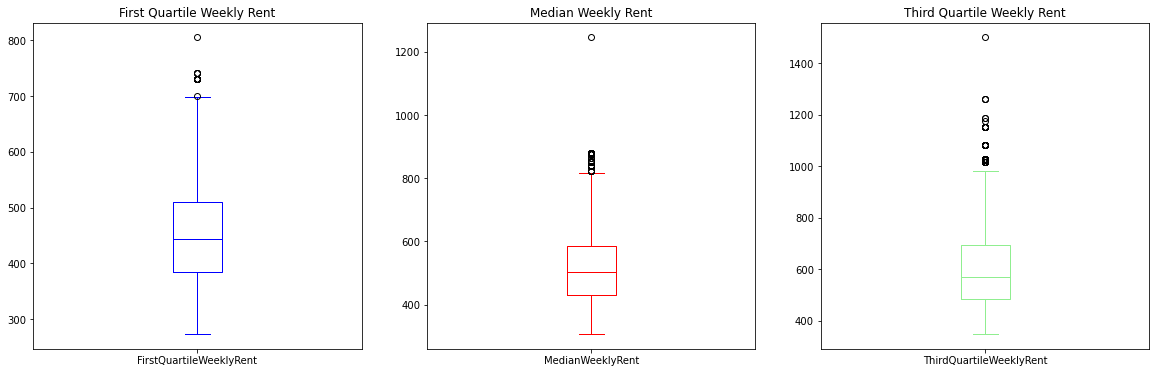

In [21]:
import matplotlib.pyplot as plt

df3 = pd.DataFrame(columns=['Suburb', 'FirstQuartileWeeklyRent', 'MedianWeeklyRent', 'ThirdQuartileWeeklyRent'])
df2['FirstQuartileWeeklyRent'] = df2['FirstQuartileWeeklyRent'].replace(',','', regex=True)
df2['FirstQuartileWeeklyRent'] = df2['FirstQuartileWeeklyRent'].astype(np.int64)
df2['MedianWeeklyRent'] = df2['MedianWeeklyRent'].replace(',','', regex=True)
df2['MedianWeeklyRent'] = df2['MedianWeeklyRent'].astype(np.int64)
df2['ThirdQuartileWeeklyRent'] = df2['ThirdQuartileWeeklyRent'].replace(',','', regex=True)
df2['ThirdQuartileWeeklyRent'] = df2['ThirdQuartileWeeklyRent'].astype(np.int64)

for index, row in df2.iterrows():
    suburb = df2.iloc[index]['Suburb']
    first = df2.loc[df2['Suburb'] == suburb, 'FirstQuartileWeeklyRent'].mean()
    median = df2.loc[df2['Suburb'] == suburb, 'MedianWeeklyRent'].mean()
    third = df2.loc[df2['Suburb'] == suburb, 'ThirdQuartileWeeklyRent'].mean()
    new_row = {'Suburb' : suburb,
                   'FirstQuartileWeeklyRent' : first, 
                   'MedianWeeklyRent' : median,
                   'ThirdQuartileWeeklyRent' : third}
    df3 = df3.append(new_row, ignore_index = True)

fig = plt.figure()
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

#sub-plot1 - box plot
df3['FirstQuartileWeeklyRent'].plot(kind = 'box', color = 'blue', figsize = (20,6), ax = ax0)
ax0.set_title("First Quartile Weekly Rent")

df3['MedianWeeklyRent'].plot(kind = 'box', color = 'red', figsize = (20,6), ax = ax1)
ax1.set_title("Median Weekly Rent")

df3['ThirdQuartileWeeklyRent'].plot(kind = 'box', color = 'lightgreen', figsize = (20,6), ax = ax2)
ax2.set_title("Third Quartile Weekly Rent")

minimum_FirstQuartileWeeklyRent = np.round(np.median(df3['FirstQuartileWeeklyRent']), 2)
print('Median for FirstQuartileWeeklyRent : %s' % minimum_FirstQuartileWeeklyRent)
minimum_MedianWeeklyRent = np.round(np.median(df3['MedianWeeklyRent']), 2)
print('Median for MedianWeeklyRent : %s' % minimum_MedianWeeklyRent)
minimum_ThirdQuartileWeeklyRent = np.round(np.median(df3['ThirdQuartileWeeklyRent']), 2)
print('Median for ThirdQuartileWeeklyRent : %s' % minimum_ThirdQuartileWeeklyRent)
print()
maximum_FirstQuartileWeeklyRent = np.round(df3['FirstQuartileWeeklyRent'].quantile(0.75), 2)
print('75th percentile for FirstQuartileWeeklyRent : %s' % maximum_FirstQuartileWeeklyRent)
maximum_MedianWeeklyRent = np.round(df3['MedianWeeklyRent'].quantile(0.75), 2)
print('75th percentile for MedianWeeklyRent : %s' % maximum_MedianWeeklyRent)
maximum_ThirdQuartileWeeklyRent = np.round(df3['ThirdQuartileWeeklyRent'].quantile(0.75), 2)
print('75th percentile for ThirdQuartileWeeklyRent : %s' % maximum_ThirdQuartileWeeklyRent)
print()

#### As we can see from the above plots, the median rents for every quartile are displayed. We wish that our ideal property rent will be above this median and below the 75th quartile.

#### Let's now plot the total number of bonds lodged in each suburb

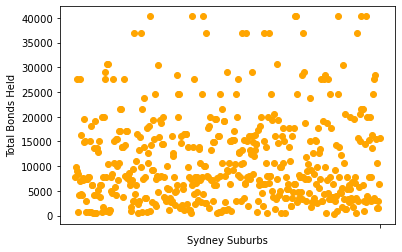

Suburbs with maximum number of total bonds lodged (>35000) : 
casula
chipping norton
constitution hill
girraween
greystanes
hammondville
liverpool
lurnea
moorebank
mount pritchard
pemulwuy
pendle hill
prestons
south wentworthville
warwick farm
wentworthville
westmead


In [22]:
df2['TotalBondsHeld'] = df2['TotalBondsHeld'].replace(',','', regex=True)
df2['TotalBondsHeld'] = df2['TotalBondsHeld'].astype(np.int64)
plot_dict = {}
for index, row in df2.iterrows():
    suburb = df2.iloc[index]['Suburb']
    total = df2.loc[df2['Suburb'] == suburb, 'TotalBondsHeld'].sum()
    plot_dict.update({suburb : total})
    
x = plot_dict.keys()
y = plot_dict.values()

plt.scatter(x, y, color='orange')
plt.xticks('')
plt.xlabel("Sydney Suburbs")
plt.ylabel("Total Bonds Held")
plt.show()
list1 = []
print("Suburbs with maximum number of total bonds lodged (>35000) : ")
for i,j in zip(x,y):
    if j>35000:
        list1.append(i)
        print(i)

#### Let's now plot the number of new bonds lodged in each suburb

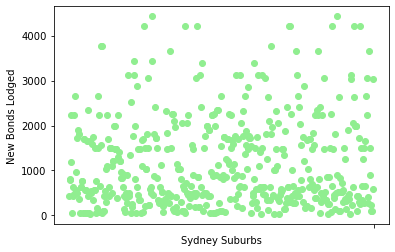

Suburbs with maximum number of new bonds lodged (>4000) : 
constitution hill
darlinghurst
girraween
greystanes
pemulwuy
pendle hill
south wentworthville
surry hills
wentworthville
westmead


In [23]:
df2['NewBondsLodged'] = df2['NewBondsLodged'].replace(',','', regex=True)
df2['NewBondsLodged'] = df2['NewBondsLodged'].astype(np.int64)
plot_dict = {}
for index, row in df2.iterrows():
    suburb = df2.iloc[index]['Suburb']
    total = df2.loc[df2['Suburb'] == suburb, 'NewBondsLodged'].sum()
    plot_dict.update({suburb : total})
    
x = plot_dict.keys()
y = plot_dict.values()

plt.scatter(x, y, color='lightgreen')
plt.xticks('')
plt.xlabel("Sydney Suburbs")
plt.ylabel("New Bonds Lodged")
plt.show()
list2 = []
print("Suburbs with maximum number of new bonds lodged (>4000) : ")
for i,j in zip(x,y):
    if j>4000:
        list2.append(i)
        print(i)

#### Let's now plot the annual change in weekly rent in each suburb

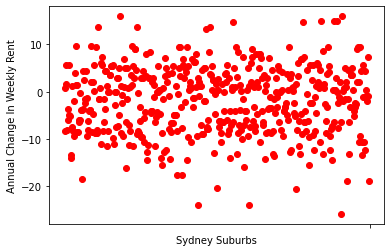

Suburbs with maximum positive change(increase) in annual rent(>10%) : 
bonnet bay
carramar
como
hunters hill
jannali
londonderry
richmond
st peters
sydenham
tempe
villawood


In [24]:
plot_dict = {}
for index, row in df2.iterrows():
    suburb = df2.iloc[index]['Suburb']
    meanOfChange = df2.loc[df2['Suburb'] == suburb, 'AnnualChangeInWeeklyRent'].mean()
    plot_dict.update({suburb : meanOfChange})
    
x = plot_dict.keys()
y = plot_dict.values()

plt.scatter(x, y, color='red')
plt.xticks('')
plt.xlabel("Sydney Suburbs")
plt.ylabel("Annual Change In Weekly Rent")
plt.show()
list3 = []
print("Suburbs with maximum positive change(increase) in annual rent(>10%) : ")
for i,j in zip(x,y):
    if j>10.0:
        list3.append(i)
        print(i)

#### A negative change in the above plot implies that the rent has reduced by that percentage which is not desirable by the owner. On the other hand, a positive change implies that the rent has increased annually, which was actually accepted by the tenants. This is a sign of profit to the owner, hence we will consider positive change only.

## Results and Discussion

In [26]:
all_suburbs = list1+list2+list3
df4 = pd.DataFrame(columns=['Suburb', 'FirstQuartileWeeklyRent', 'MedianWeeklyRent', 'ThirdQuartileWeeklyRent', 'TrainStationPresent'])
df4['Suburb'] = all_suburbs
for index, row in df4.iterrows():
    suburb = df4.iloc[index]['Suburb']
    df4.iloc[index]['FirstQuartileWeeklyRent'] = df2.loc[df2['Suburb'] == suburb, 'FirstQuartileWeeklyRent'].mean()
    df4.iloc[index]['MedianWeeklyRent'] = df2.loc[df2['Suburb'] == suburb, 'MedianWeeklyRent'].mean()
    df4.iloc[index]['ThirdQuartileWeeklyRent'] = df2.loc[df2['Suburb'] == suburb, 'ThirdQuartileWeeklyRent'].mean()
    df4.iloc[index]['TrainStationPresent'] = df2.loc[df2['Suburb'] == suburb, 'TrainStationPresent'].any()
    #df4.iloc[index]['Woolworths'] = df2.loc[df2['Suburb'] == suburb, 'Woolworths'].any()
    #df4.iloc[index]['Coles'] = df2.loc[df2['Suburb'] == suburb, 'Coles'].any()

#### Remove suburbs which do not have weekly rents falling between 50th percentile and 75th percentile from the box plots 

In [27]:
first_quartile_suburbs = []
median_quartile_suburbs = []
third_quartile_suburbs = []

for index, row in df4.iterrows():
    suburb = df4.iloc[index]['Suburb']
    if df4.iloc[index]['FirstQuartileWeeklyRent']>=minimum_FirstQuartileWeeklyRent and df4.iloc[index]['FirstQuartileWeeklyRent']<=maximum_FirstQuartileWeeklyRent:
        first_quartile_suburbs.append(suburb)
    if df4.iloc[index]['MedianWeeklyRent']>=minimum_FirstQuartileWeeklyRent and df4.iloc[index]['MedianWeeklyRent']<=maximum_FirstQuartileWeeklyRent:
        median_quartile_suburbs.append(suburb)
    if df4.iloc[index]['ThirdQuartileWeeklyRent']>=minimum_FirstQuartileWeeklyRent and df4.iloc[index]['ThirdQuartileWeeklyRent']<=maximum_FirstQuartileWeeklyRent:
        third_quartile_suburbs.append(suburb)

df5 = pd.DataFrame(columns=['Suburb', 'FirstQuartileWeeklyRent', 'MedianWeeklyRent', 'ThirdQuartileWeeklyRent', 'TrainStationPresent'])
common_suburbs = list(set(median_quartile_suburbs) & set(third_quartile_suburbs))
print(common_suburbs)
df4.drop_duplicates(subset ="Suburb", keep = 'first', inplace = True)
df4 = df4.reset_index()
for index, row in df4.iterrows():
    suburb = df4.iloc[index]['Suburb']
    if suburb in common_suburbs:
        df5 = df5.append(row, ignore_index = True)
        
df5 = df5.drop(columns=['index'])

['wentworthville', 'girraween', 'greystanes', 'pemulwuy', 'south wentworthville', 'pendle hill', 'constitution hill', 'westmead']


#### Get supermarkets(woolworths or coles, if present) in filtered suburbs using FourSquare API

In [31]:
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

CLIENT_ID = 'LE5X4S455AHFUXDAZJ4FKFYUMKWCGFYBYQFA3ALMBZKMGCGC' # your Foursquare ID
CLIENT_SECRET = 'OLQXUUHLXVEMB2KI4UL3X4UPGMCTADCNW1XXO3S0RIHN1QRI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

woolworths_column = pd.DataFrame(columns=['Woolworths'])
df5 = df5.append(woolworths_column)

coles_column = pd.DataFrame(columns=['Coles'])
df5 = df5.append(coles_column)

for index, row in df5.iterrows():
    suburb = df5.iloc[index]['Suburb']
    #postcode = df2.iloc[index]['PostCode']
    #address = suburb+', '+str(postcode)+', '+' NSW'
    address = suburb+', '+'NSW'

    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    search_query = ['Woolworths', 'Coles']
    for query in search_query:
        radius = 1000
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, query, radius, LIMIT)
        results = requests.get(url).json()
        #print(results)
        if len(results['response']) != 0:
            venues = results['response']['venues']
            dataframe = json_normalize(venues)

            if dataframe.empty == False:
                filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
                dataframe_filtered = dataframe.loc[:, filtered_columns]

                # function that extracts the category of the venue
                def get_category_type(row):
                    try:
                        categories_list = row['categories']
                    except:
                        categories_list = row['venue.categories']

                    if len(categories_list) == 0:
                        return None
                    else:
                        return categories_list[0]['name']

                # filter the category for each row
                dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

                # clean column names by keeping only last term
                dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
                if dataframe_filtered.name.any() == "Woolworths":
                    #print("WYes")
                    df5.loc[df5['Suburb'] == suburb, 'Woolworths'] = 1
                if dataframe_filtered.name.any() == "Coles":
                    #print("CYes")
                    df5.loc[df5['Suburb'] == suburb, 'Coles'] = 1
            else:
                if query == 'Woolworths':
                    #print("WNo")
                    df5.loc[df5['Suburb'] == suburb, 'Woolworths'] = 0
                elif query == 'Coles':
                    #print("CNo")
                    df5.loc[df5['Suburb'] == suburb, 'Coles'] = 0
                    
df5.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,Suburb,FirstQuartileWeeklyRent,MedianWeeklyRent,ThirdQuartileWeeklyRent,TrainStationPresent,Woolworths,Coles
0,constitution hill,406.736842,455.157895,502.473684,False,0,0
1,girraween,406.736842,455.157895,502.473684,False,0,0
2,greystanes,406.736842,455.157895,502.473684,False,1,0
3,pemulwuy,406.736842,455.157895,502.473684,False,1,0
4,pendle hill,406.736842,455.157895,502.473684,True,0,0
5,south wentworthville,406.736842,455.157895,502.473684,False,1,0
6,wentworthville,406.736842,455.157895,502.473684,True,1,1
7,westmead,406.736842,455.157895,502.473684,True,0,1


#### To summarize the capstone, we have initially started off with collecting relevant and required data for choosing an ideal suburb. We then chose our main features to be weekly rent in each quartile of the year, total bonds lodged and change in annual rent (whether positive or negative). Upon obtaining a few common suburbs satisfying the conditions for ideal suburb, we then moved to filter the suburbs further based on amenities such as close-by train stations and supermarkets.

## Conclusion

#### From the above dataframe, we can observe that there are 8 suburbs which satisfy the good profit weekly rent for first, median and third quartile. Among these, thinking from the tenant's point of view, we can say that most of the tenants prefer residing in suburbs which have easy access to transportation (train stations) and supermarkets so that they do not have to travel long distances to access these amenities. This will be profitable for the owner as more and more people will approach the property for tenancy. Hence, Wentworthville is chosen to be the ideal suburb for property purchase for maximum profit to the owner.